<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#get_yerr" data-toc-modified-id="get_yerr-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get_yerr</a></span></li><li><span><a href="#load_house_price_X_y" data-toc-modified-id="load_house_price_X_y-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>load_house_price_X_y</a></span></li><li><span><a href="#get_metrics" data-toc-modified-id="get_metrics-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>get_metrics</a></span></li><li><span><a href="#PoissonConformityScore" data-toc-modified-id="PoissonConformityScore-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PoissonConformityScore</a></span></li><li><span><a href="#TweedieConformityScore" data-toc-modified-id="TweedieConformityScore-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>TweedieConformityScore</a></span></li></ul></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Perform-experiments" data-toc-modified-id="Perform-experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Perform experiments</a></span></li><li><span><a href="#Illustrate" data-toc-modified-id="Illustrate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Illustrate</a></span><ul class="toc-item"><li><span><a href="#Appropriate-non-conformity-scores" data-toc-modified-id="Appropriate-non-conformity-scores-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Appropriate non conformity scores</a></span></li><li><span><a href="#Limit-of-standard-non-conformity-score" data-toc-modified-id="Limit-of-standard-non-conformity-score-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Limit of standard non conformity score</a></span></li></ul></li></ul></div>

___
# Packages

In [1]:
%load_ext nb_black

from zipfile import ZipFile
from urllib.request import urlopen

from lightgbm import LGBMRegressor
from mapie._machine_precision import EPSILON
from mapie._typing import ArrayLike, NDArray
from mapie.conformity_scores import AbsoluteConformityScore, ConformityScore
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

___
# Functions

## get_yerr

In [2]:
##############################################################################
# Prepare the results for matplotlib. Get the prediction intervals and their
# corresponding widths.
def get_yerr(y_pred, y_pis):
    return np.concatenate(
        [
            np.expand_dims(y_pred, 0) - y_pis[:, 0, 0].T,
            y_pis[:, 1, 0].T - np.expand_dims(y_pred, 0),
        ],
        axis=0,
    )

<IPython.core.display.Javascript object>

## load_house_price_X_y

In [3]:
def load_house_price_X_y():
    features = [
        "MSSubClass",
        "LotArea",
        "OverallQual",
        "OverallCond",
        "GarageArea",
    ]

    X, y = fetch_openml(name="house_prices", return_X_y=True)
    return X[features], y

<IPython.core.display.Javascript object>

## get_metrics

In [4]:
def get_metrics(y_test, y_pred, y_pis, n_bins=10):
    metrics = {}

    # global coverage score
    coverage_score = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
    metrics["coverage_score"] = coverage_score

    # mean prediction interval
    pred_int_width = y_pis[:, 1, 0] - y_pis[:, 0, 0]
    mean_pred_int_width = np.mean(pred_int_width)
    metrics["mean_pred_int_width"] = mean_pred_int_width

    # local coverage score
    bins = np.quantile(y_test, np.linspace(0, 1, n_bins + 1))
    bins[-1] += 1
    bin_ids = np.digitize(y_test, bins)
    coverage_score_list = []
    n_obs_list = []
    for bin_id in np.unique(bin_ids):
        coverage_score_list.append(
            regression_coverage_score(
                y_test[bin_ids == bin_id],
                y_pis[bin_ids == bin_id, 0, 0],
                y_pis[bin_ids == bin_id, 1, 0],
            )
        )
        n_obs_list.append(np.sum(bin_ids == bin_id))
    local_coverage_score = {
        f"[{bins[ii]},{bins[ii+1]})": {
            "n_obs": n_obs_list[ii],
            "coverage_score": coverage_score_list[ii],
            "mid_bin": (bins[ii] + bins[ii + 1]) / 2,
        }
        for ii in range(len(coverage_score_list))
    }
    metrics["local_coverage_score"] = local_coverage_score

    return metrics

<IPython.core.display.Javascript object>

## PoissonConformityScore

In [5]:
class PoissonConformityScore(ConformityScore):
    """
    Poisson conformity score.

    The signed conformity score = (y - y_pred) / y_pred**(1/2).
    The conformity score is not symmetrical.
    y must be positive
    y_pred must be strictly positive

    This is appropriate when the confidence interval is not symmetrical and
    its range depends on the predicted values.
    """

    def __init__(
        self,
    ) -> None:
        super().__init__(sym=False, consistency_check=False, eps=EPSILON)

    def _check_observed_data(
        self,
        y: ArrayLike,
    ) -> None:
        if not self._all_positive(y):
            raise ValueError(
                f"At least one of the observed target is strictly negative "
                f"which is incompatible with {self.__class__.__name__}. "
                "All values must be positive."
            )

    def _check_predicted_data(
        self,
        y_pred: ArrayLike,
    ) -> None:
        if not self._all_strictly_positive(y_pred):
            raise ValueError(
                f"At least one of the predicted target is negative "
                f"which is incompatible with {self.__class__.__name__}. "
                "All values must be strictly positive."
            )

    @staticmethod
    def _all_positive(
        y: ArrayLike,
    ) -> bool:
        return np.all(np.greater_equal(y, 0))

    @staticmethod
    def _all_strictly_positive(
        y: ArrayLike,
    ) -> bool:
        return np.all(np.greater(y, 0))

    def get_signed_conformity_scores(
        self,
        X: ArrayLike,
        y: ArrayLike,
        y_pred: ArrayLike,
    ) -> NDArray:
        """
        Compute the signed conformity scores from the observed values
        and the predicted ones, from the following formula:
        signed conformity score = (y - y_pred) / y_pred**(1/2)
        """
        self._check_observed_data(y)
        self._check_predicted_data(y_pred)
        return np.divide(np.subtract(y, y_pred), np.power(y_pred, 1 / 2))

    def get_estimation_distribution(
        self, X: ArrayLike, y_pred: ArrayLike, conformity_scores: ArrayLike
    ) -> NDArray:
        """
        Compute samples of the estimation distribution from the predicted
        values and the conformity scores, from the following formula:
        signed conformity score = (y - y_pred) / y_pred**(1/2)
        <=> y = y_pred + y_pred**(1/2) * signed conformity score

        ``conformity_scores`` can be either the conformity scores or
        the quantile of the conformity scores.
        """
        self._check_predicted_data(y_pred)
        return np.add(y_pred, np.multiply(np.power(y_pred, 1 / 2), conformity_scores))

<IPython.core.display.Javascript object>

## TweedieConformityScore

In [6]:
class TweedieConformityScore(ConformityScore):
    """
    Tweedie conformity score.

    The signed conformity score = (y - y_pred) / y_pred**(p/2).
    The conformity score is not symmetrical.
    y must be positive
    y_pred must be strictly positive

    This is appropriate when the confidence interval is not symmetrical and
    its range depends on the predicted values.
    """

    def __init__(self, p) -> None:
        self.p = p
        super().__init__(sym=False, consistency_check=False, eps=EPSILON)

    def _check_observed_data(
        self,
        y: ArrayLike,
    ) -> None:
        if not self._all_positive(y):
            raise ValueError(
                f"At least one of the observed target is strictly negative "
                f"which is incompatible with {self.__class__.__name__}. "
                "All values must be positive."
            )

    def _check_predicted_data(
        self,
        y_pred: ArrayLike,
    ) -> None:
        if not self._all_strictly_positive(y_pred):
            raise ValueError(
                f"At least one of the predicted target is negative "
                f"which is incompatible with {self.__class__.__name__}. "
                "All values must be strictly positive."
            )

    @staticmethod
    def _all_positive(
        y: ArrayLike,
    ) -> bool:
        return np.all(np.greater_equal(y, 0))

    @staticmethod
    def _all_strictly_positive(
        y: ArrayLike,
    ) -> bool:
        return np.all(np.greater(y, 0))

    def get_signed_conformity_scores(
        self,
        X: ArrayLike,
        y: ArrayLike,
        y_pred: ArrayLike,
    ) -> NDArray:
        """
        Compute the signed conformity scores from the observed values
        and the predicted ones, from the following formula:
        signed conformity score = (y - y_pred) / y_pred**(1/2)
        """
        self._check_observed_data(y)
        self._check_predicted_data(y_pred)
        return np.divide(np.subtract(y, y_pred), np.power(y_pred, self.p / 2))

    def get_estimation_distribution(
        self, X: ArrayLike, y_pred: ArrayLike, conformity_scores: ArrayLike
    ) -> NDArray:
        """
        Compute samples of the estimation distribution from the predicted
        values and the conformity scores, from the following formula:
        signed conformity score = (y - y_pred) / y_pred**(1/2)
        <=> y = y_pred + y_pred**(1/2) * signed conformity score

        ``conformity_scores`` can be either the conformity scores or
        the quantile of the conformity scores.
        """
        self._check_predicted_data(y_pred)
        return np.add(
            y_pred, np.multiply(np.power(y_pred, self.p / 2), conformity_scores)
        )

<IPython.core.display.Javascript object>

___
# Parameters

In [7]:
np.random.seed(0)

alpha = 0.05
method = {"method": "plus", "cv": 5}
conformity_scores = [
    AbsoluteConformityScore(),
    PoissonConformityScore(),
    TweedieConformityScore(2),
]
lgbm_kwargs = {"n_estimators": 100, "random_state": 0}
test_size = 0.5
n_bins = 7

<IPython.core.display.Javascript object>

___
# Perform experiments

In [9]:
X, y = load_house_price_X_y()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
metrics = {}
predictions = {}
for conformity_score in conformity_scores:
    mapie = MapieRegressor(
        LGBMRegressor(**lgbm_kwargs),
        **method,
        conformity_score=conformity_score,
    )
    mapie.fit(X_train, y_train)
    y_pred, y_pis = mapie.predict(X_test, alpha=alpha)
    yerr = get_yerr(y_pred, y_pis)
    pred_int_width = y_pis[:, 1, 0] - y_pis[:, 0, 0]

    metrics[conformity_score.__class__.__name__] = get_metrics(
        y_test, y_pred, y_pis, n_bins=n_bins
    )
    predictions[conformity_score.__class__.__name__] = {
        "y_pred": y_pred,
        "yerr": yerr,
        "pred_int_width": pred_int_width,
    }

/home/capitaine/01_projects/2022/mapie/TDS/venv_custom_non_conformity_score/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 730, number of used features: 5
[LightGBM] [Info] Start training from score 181302.582192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 730, number of used features: 5
[LightGBM] [Info] Start training from score 181302.582192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 730, number of used features: 5
[LightGBM] [Info] Start training from score 181302.582192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 5
[LightGBM] [Info] Start training from score 182560.986301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

<IPython.core.display.Javascript object>

___
# Illustrate

In [10]:
def subplot_single_non_conformity_score(
    axs, y_test, predictions, metrics, conformity_score_name
):
    # predictions and prediction intervals
    axs[0].errorbar(
        y_test,
        predictions["y_pred"],
        yerr=predictions["yerr"],
        alpha=0.5,
        linestyle="None",
    )
    axs[0].scatter(y_test, predictions["y_pred"], s=1, color="black")
    axs[0].plot(
        [0, max(max(y_test), max(predictions["y_pred"]))],
        [0, max(max(y_test), max(predictions["y_pred"]))],
        "-r",
    )
    axs[0].set_xlabel("Actual price [$]")
    axs[0].set_ylabel("Predicted price [$]")
    axs[0].grid()
    axs[0].set_title(
        f"{conformity_score_name} - coverage={metrics['coverage_score']:.0%}"
    )
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    # prediction interval widths
    axs[1].scatter(y_test, predictions["pred_int_width"], marker="+")
    axs[1].set_xlabel("Actual price [$]")
    axs[1].set_ylabel("Prediction interval width [$]")
    axs[1].grid()
    axs[1].set_xlim([xmin, xmax])
    axs[1].set_ylim([ymin, ymax])

    # local coverages
    x = []
    y = []
    for k, v in metrics["local_coverage_score"].items():
        x.append(v["mid_bin"])
        y.append(v["coverage_score"])
    axs[2].plot(
        x,
        y,
        ":+",
        label="local",
    )
    axs[2].hlines(
        metrics["coverage_score"],
        min(y_test),
        max(y_test),
        label="global",
    )
    axs[2].set_xlim([xmin, xmax])
    axs[2].set_ylim([0.6, 1.02])
    axs[2].grid()
    axs[2].set_xlabel("Actual price [$]")
    axs[2].set_ylabel("Coverage score")
    axs[2].legend(title="Coverage score", loc=3)

<IPython.core.display.Javascript object>

## Appropriate non conformity scores

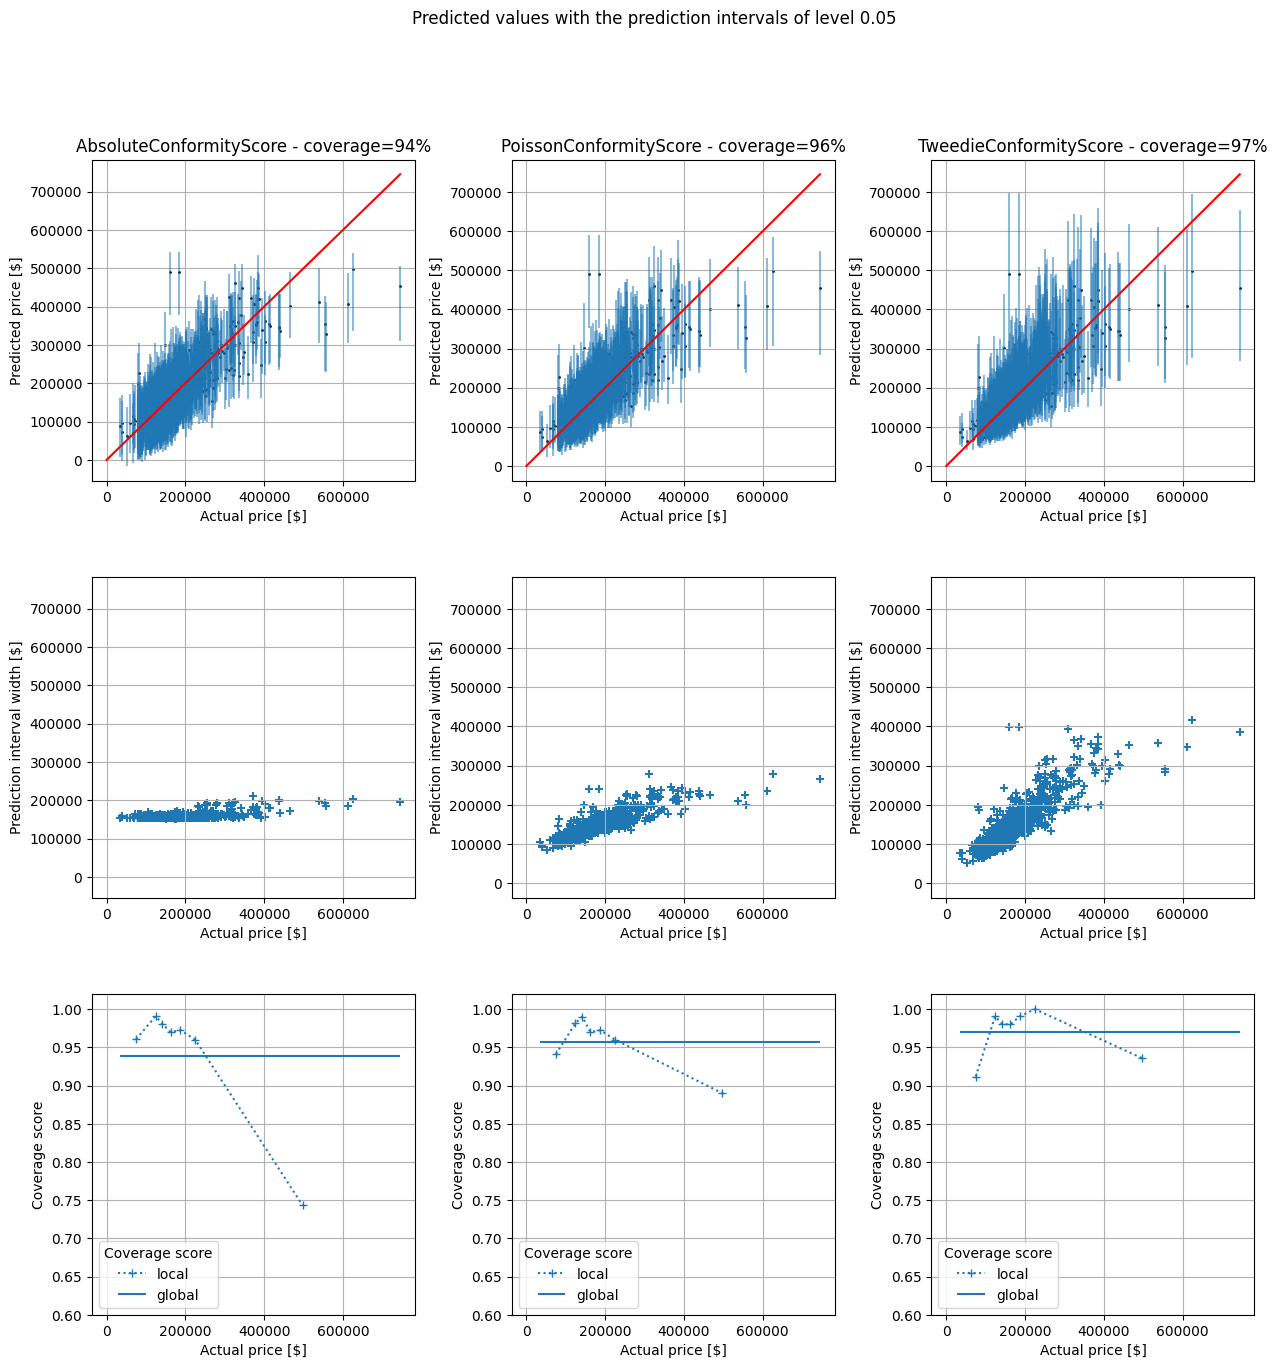

<IPython.core.display.Javascript object>

In [11]:
#####################################
# 3. Compare the prediction intervals
# -----------------------------------
#
# Once the models have been trained, we now compare the prediction intervals
# obtained from the three conformity scores. We can see that the
# :class:AbsoluteConformityScore generates prediction interval with almost the
# same width for all the predicted values. Conversely, the PoissonConformityScore
# and TweedieConformityScore yields prediction interval with width scaling
# with the predicted values.
#
# The choice of the conformity score depends on the problem we face.

fig, axs = plt.subplots(3, len(predictions), figsize=(len(predictions) * 5, 3 * 5))
img_id = 0
for conformity_score in conformity_scores:
    conformity_score_name = conformity_score.__class__.__name__
    subplot_single_non_conformity_score(
        axs[:, img_id],
        y_test,
        predictions[conformity_score_name],
        metrics[conformity_score_name],
        conformity_score_name,
    )
    img_id += 1

fig.suptitle(f"Predicted values with the prediction intervals of level {alpha}")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Limit of standard non conformity score

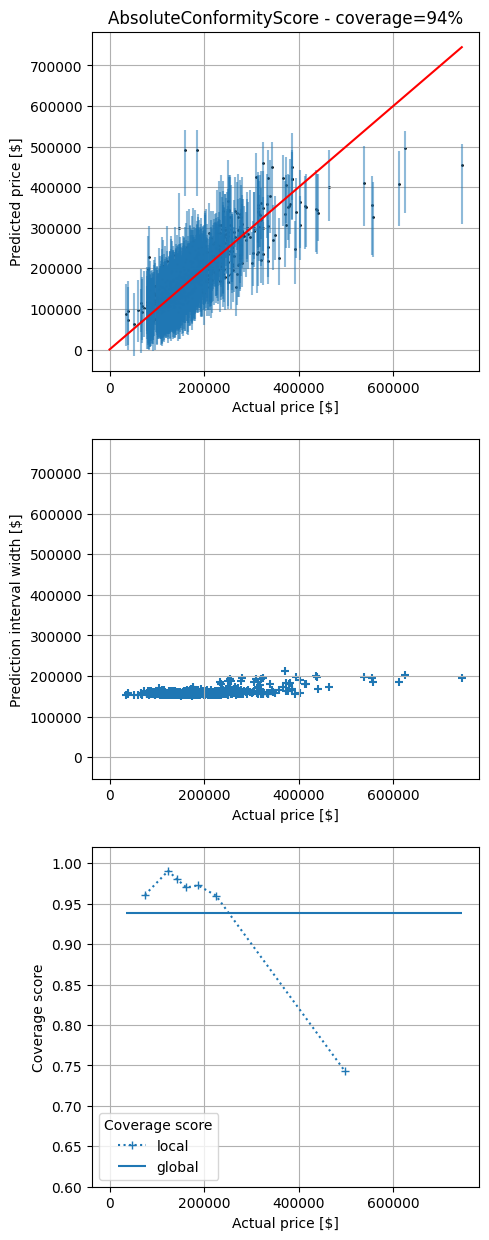

<IPython.core.display.Javascript object>

In [13]:
predictions = {k: v for k, v in predictions.items() if k == "AbsoluteConformityScore"}
metrics = {k: v for k, v in metrics.items() if k == "AbsoluteConformityScore"}
conformity_scores = [AbsoluteConformityScore()]

fig, axs = plt.subplots(3, len(predictions), figsize=(len(predictions) * 5, 3 * 5))
img_id = 0
for conformity_score in conformity_scores:
    conformity_score_name = conformity_score.__class__.__name__
    subplot_single_non_conformity_score(
        axs,
        y_test,
        predictions[conformity_score_name],
        metrics[conformity_score_name],
        conformity_score_name,
    )
    img_id += 1
axs[0].set_xticks([0, 200000, 400000, 600000])
axs[1].set_xticks([0, 200000, 400000, 600000])
axs[2].set_xticks([0, 200000, 400000, 600000])